## DC2 Classification Accuracy

In [1]:
import torch
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from hydra import initialize, compose
from hydra.utils import instantiate

from case_studies.dc2_cataloging.utils.load_full_cat import get_full_cat
from case_studies.dc2_cataloging.utils.safe_metric_collection import SafeMetricCollection as MetricCollection

output_dir = Path("./classification_accuracy_output/")
output_dir.mkdir(parents=True, exist_ok=True)

# change this model path according to your training setting
model_path = "../../../bliss_output/DC2_cataloging_exp/exp_06-16-2/checkpoints/best_encoder.ckpt"
lsst_root_dir = "/data/scratch/dc2_nfs/"

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [2]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_config")

In [3]:
test_image_idx = 0
test_image, test_image_cat, bliss_full_cat, _ = get_full_cat(notebook_cfg, 
                                                             test_image_idx, 
                                                             model_path, 
                                                             lsst_root_dir, 
                                                             device)
image_lim = test_image.shape[1]
test_image = test_image[2]  # r-band

In [4]:
matcher = instantiate(notebook_cfg.encoder.matcher)
bliss_metrics = instantiate(notebook_cfg.encoder.metrics)
bliss_metrics = MetricCollection({
    "source_type_accuracy": bliss_metrics["source_type_accuracy"],
    "source_type_accuracy_star": bliss_metrics["source_type_accuracy_star"],
    "source_type_accuracy_galaxy": bliss_metrics["source_type_accuracy_galaxy"],
}).to(device=device)

flux_bin_cutoffs = bliss_metrics["source_type_accuracy"].flux_bin_cutoffs

bliss_results = {}

classification_result_path = output_dir / "classification_result.pkl"
if not classification_result_path.exists():
    bliss_matching = list(matcher.match_catalogs(test_image_cat, bliss_full_cat)[0])
    
    bliss_metrics.update(test_image_cat, bliss_full_cat, [bliss_matching])
    for k, v in bliss_metrics.items():
        resutls = v.get_results_on_per_flux_bin()
        for k_results, v_results in resutls.items():
            bliss_results[k_results] = v_results.cpu()

        internal_states = v.get_internal_states()
        for k_states, v_states in internal_states.items():
            bliss_results[k_states] = v_states.cpu()

        with open(classification_result_path, "wb") as classification_result_file:
                pickle.dump({
                    "bliss_results": bliss_results,
                }, classification_result_file, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(classification_result_path, "rb") as classification_result_file:
          classification_result = pickle.load(classification_result_file)
    bliss_results = classification_result["bliss_results"]

In [5]:
def plot(classification_acc,
         classification_acc_star,
         classification_acc_galaxy,
         internal_states,
         internal_states_star,
         internal_states_galaxy,
         flux_bin_cutoffs):
    xlabels = (
        ["[100, " + str(flux_bin_cutoffs[0]) + "]"]
        + [f"[{flux_bin_cutoffs[i]}, {flux_bin_cutoffs[i + 1]}]" for i in range(len(flux_bin_cutoffs) - 1)]
        + ["> " + str(flux_bin_cutoffs[-1])]
    )

    bar_plot_data = {
        "Star TP": internal_states["star_tp"],
        "# Star": internal_states_star["n_matches_star"],
        "Galaxy TP": internal_states["gal_tp"],
        "# Galaxy": internal_states_galaxy["n_matches_galaxy"]
    }

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(
        1, 1, layout="constrained"
    )
    color_list = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    x = np.arange(len(xlabels)) * 45
    width = 10
    multiplier = 0

    for i, (data_name, data) in enumerate(bar_plot_data.items()):
        offset = width * multiplier
        rects = ax.bar(x + offset, data, width, color=color_list[i], label=data_name)
        ax.bar_label(rects, padding=3, fontsize=6)
        multiplier += 1

    ax.set_ylabel("Count")
    ax.set_xlabel("Flux")
    ax.set_xticks(x + width)
    ax.set_xticklabels(xlabels, rotation=45)
    ax.set_yscale("log")
    ax.set_ylim(top=1e5)
    ax.grid(visible=False, axis="x")
    ax.legend(loc="lower right")
    
    ax2 = ax.twinx()
    
    acc_p,  = ax2.plot(
        x + width,
        classification_acc.tolist(),
        "-o",
        color=color_list[4],
        label=f"BLISS Acc",
    )
    acc_star_p,  = ax2.plot(
        x + width,
        classification_acc_star.tolist(),
        "-o",
        color=color_list[5],
        label=f"BLISS Acc (Star)",
    )
    acc_gal_p,  = ax2.plot(
        x + width,
        classification_acc_galaxy.tolist(),
        "-o",
        color=color_list[6],
        label=f"BLISS Acc (Galaxy)",
    )
    
    ax2.set_ylabel("Classification Accuracy")
    ax2.grid(visible=False, axis="both")
    fig.legend(handles=[acc_p, acc_star_p, acc_gal_p], loc="outside upper center", ncols=3)

    return fig, ax

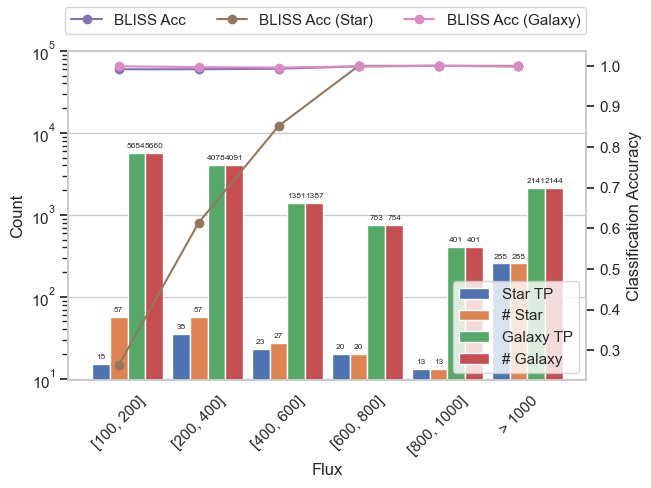

In [6]:
fig, ax = plot(bliss_results["classification_acc"],
               bliss_results["classification_acc_star"],
               bliss_results["classification_acc_galaxy"],
               {
                   "n_matches": bliss_results["n_matches"],
                   "gal_tp": bliss_results["gal_tp"],
                   "star_tp": bliss_results["star_tp"],
               },
               {
                   "n_matches_star": bliss_results["n_matches_star"],
                   "gal_tp_star": bliss_results["gal_tp_star"],
                   "star_tp_star": bliss_results["star_tp_star"],
               },
               {
                   "n_matches_galaxy": bliss_results["n_matches_galaxy"],
                   "gal_tp_galaxy": bliss_results["gal_tp_galaxy"],
                   "star_tp_galaxy": bliss_results["star_tp_galaxy"],
               },
               flux_bin_cutoffs=flux_bin_cutoffs)
fig.savefig(output_dir / "classification_acc.pdf", bbox_inches="tight")
fig.show()

In [14]:
matcher = instantiate(notebook_cfg.encoder.matcher)
color_list = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plocs_box_len = 100
output_img_dir = output_dir / "images"
output_img_dir.mkdir(exist_ok=True)
for i in range(0, image_lim, plocs_box_len):
    for j in range(0, image_lim, plocs_box_len):
        plocs_box_origin = torch.tensor([i, j])

        cur_target_full_cat = test_image_cat.filter_full_catalog_by_ploc_box(plocs_box_origin, plocs_box_len)
        cur_bliss_full_cat = bliss_full_cat.filter_full_catalog_by_ploc_box(plocs_box_origin, plocs_box_len)
        bliss_matching = matcher.match_catalogs(cur_target_full_cat, cur_bliss_full_cat)[0]

        true_fluxes = cur_target_full_cat.on_fluxes[0, bliss_matching[0].tolist(), 2].contiguous()  # r-band flux
        true_galaxy = cur_target_full_cat.galaxy_bools[0, bliss_matching[0].tolist(), 0]
        bliss_galaxy = cur_bliss_full_cat.galaxy_bools[0, bliss_matching[1].tolist(), 0]
        cur_target_plocs = cur_target_full_cat["plocs"][0, bliss_matching[0].tolist()]

        missing_match = (true_galaxy != bliss_galaxy)
        if missing_match.sum().item() == 0:
            continue

        galaxy_missing_match = (missing_match & true_galaxy)
        star_missing_match = (missing_match & (~true_galaxy))

        fig,ax = plt.subplots(figsize=(8, 8))
        image_sub = test_image[i:(i + plocs_box_len), j:(j + plocs_box_len)]
        ax.imshow(np.log((image_sub - image_sub.min()) + 80), cmap="viridis")
        missclassified_galaxy_x = cur_target_plocs[galaxy_missing_match, 1].tolist()
        missclassified_galaxy_y = cur_target_plocs[galaxy_missing_match, 0].tolist()
        missclassified_galaxy_flux = true_fluxes[galaxy_missing_match].tolist()
        ax.scatter(missclassified_galaxy_x, 
                   missclassified_galaxy_y, 
                   facecolors="none", edgecolors=color_list[0], 
                   alpha=1, s=130, linewidth=3, label="Missclassified Galaxy")
        for flux, x, y in zip(missclassified_galaxy_flux, missclassified_galaxy_x, missclassified_galaxy_y):
            ax.annotate(f"flux: {flux:.3g}", (x, y), textcoords="offset points", xytext=(5, 5), ha="center",
                        fontsize=12, color="lightgrey", fontweight="bold")

        missclassified_star_x = cur_target_plocs[star_missing_match, 1].tolist()
        missclassified_star_y = cur_target_plocs[star_missing_match, 0].tolist()
        missclassified_star_flux = true_fluxes[star_missing_match].tolist()
        ax.scatter(missclassified_star_x, 
                   missclassified_star_y, 
                   facecolors="none", edgecolors=color_list[1], 
                   alpha=1, s=130, linewidth=3, label="Missclassified Star")
        for flux, x, y in zip(missclassified_star_flux, missclassified_star_x, missclassified_star_y):
            ax.annotate(f"flux: {flux:.3g}", (x, y), textcoords="offset points", xytext=(5, 5), ha="center",
                        fontsize=12, color="lightgrey", fontweight="bold")

        ax.legend()
        fig.savefig(output_img_dir / f"image_{test_image_idx}_{i}_{j}.pdf", bbox_inches="tight")
        plt.close()